# CZ4042-Neural Network

## Introduction

One of the most important areas of natural language processing is sentiment analysis, which is the act of determining the sentiments represented in text or documents. We explore and apply a variety of deep learning approaches in this notebook to address three particular needs related to Text Sentiment Analysis (TSA):

### 1. Domain Adaptation
Getting a model that was trained on one domain to function well in another is one of the fundamental problems in sentiment analysis. We use a fine-tuning method on pre-trained models to solve this. In particular, we adjust movie review TSA data using the 'bert-yelp-review' model, which was trained on customer reviews. We are able to maximise the model's performance in the new domain thanks to this modification. To improve the adaptation process even further, we also experiment with hyperparameter adjustment, paying special attention to learning rates.

### 2. Comparing Transformer Architectures
We carry out an extensive benchmarking analysis in order to comprehend the performance variations across different Transformers designs. The efficacy of several models, including BERT, DistilBERT, DistilRoBERTa, BART, ALBERT, and DeBERTa, is assessed and contrasted. A crucial step in this process is hyperparameter adjustment, especially in relation to learning rates. Our goal is to determine which architecture best fits the TSA task while highlighting the advantages and disadvantages of each.

### 3. Handling Small Datasets
We tackle the third criteria, which is handling tiny datasets—a problem that TSA frequently faces. In order to get around this restriction, we use many techniques:

- Transfer Learning: We use big text corpora-trained models such as BERT, leveraging the capabilities of pre-trained models. We next use our limited dataset to fine-tune these models, making use of the knowledge that was already ingrained in the pre-trained model to improve performance.

- Regularisation methods: We use crucial regularisation methods like dropout and early halting to avoid overfitting on sparse data. These techniques contribute to the successful generalisation of our models.

- Future Development - Ensemble Methods: We use ensemble methods when we believe that using small datasets could result in unstable model predictions. We aim to improve our sentiment analysis models overall by combining predictions from multiple models, which may have been trained on different data subsets or with different architectures. Although it hasn't been finished for the current project, this section may be improved in the future.

We explore the particular approaches, applications, and outcomes that are relevant to each of these requirements in the sections that follow. By the end of this notebook, we hope to have given readers a thorough understanding of how deep learning techniques can be applied to TSA challenges in an efficient manner. This will allow us to select the best Transformers architecture for the given domain, adapt to new ones, and produce consistent results even with small datasets.

Let's now explore the specifics of our experience with the TSA.


*Note: This notebook is developed and tested on Kaggle.*

<a id="content"></a>
## Contents
* [0. Dependencies](#dependencies)
* [1. Dataset Processing & Exploration](#dataset)
    * [1.1. Loading Data](#loading)
    * [1.2. Text Cleaning](#cleaning)
    * [1.3. Dataset Visualization](#visualization)
    * [1.4. Vectorization](#vectorization)
* [2. Neural Networks](#models)
    * [2.1. Naive Bayes Classfication](#naive)
    * [2.2. Long Short Term Memory (LSTM) Classification](#lstm)
    * [2.3. Multi Channel Convolutional Neural Network(CNN)](#mchcnn)
    * [2.4. CNN_LSTM](#cnnlstm)
* [3. Transformers](#transformers)
    * [3.0. Preprocessing](#transformers_preproc)
    * [3.1. BERT](#bert)
    * [3.2. DistilBERT](#distilbert)
    * [3.3. DistilRoBERTa](#distilroberta)
    * [3.4. BART](#bart)
    * [3.5. ALBERT](#AlBERT)
    * [3.6. ALBERT for Classification](#ALBERTCls)
    * [3.7. DeBERTa](#DeBERTa)

<a id="dependencies"></a>
## [0. Dependencies](#content)

Import necessary libraries.
    

In [1]:
!pip install langdetect==1.0.9
!pip install seaborn
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=eb701d8a09ea5b3e2c3f4a7b9e3b35c2f8423b284244f1f0d8d663d6a3692ea8
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
import numpy as np
import shutil # OS interaction
import pickle # For saving and reloading data and models
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For easy progress bar
from tqdm import tqdm
tqdm.pandas()

# Below are libraries for part 2

# For text cleaning - language detection
from langdetect import detect
from langdetect import DetectorFactory

# For text cleaning - basic cleaning
from bs4 import BeautifulSoup # For removing html components
import string # For removing punctuation
import re 

# For text preprocessing - stem & lemmatize
import nltk
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# For text visualization
from collections import Counter # Count word frequency
# For word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None

# For dataset split
from sklearn.model_selection import train_test_split

# For text vectorization and label
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Base Model
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# For Neural Networks
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# For MCHCNN
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, concatenate, Dense, Embedding, Dropout

# For LSTM 
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import LSTM, SpatialDropout1D

# For CNN-LSTM
from tensorflow.keras.layers import BatchNormalization, Bidirectional

import warnings
warnings.filterwarnings('ignore')

<a id="dataset"></a>
## [1. Dataset Processing & Exploration](#content)

Here, we explore the details of our dataset, get it ready for analysis, and learn important lessons from it that will help us with the modelling and assessment that comes next.

The dataset used in this part is [IMDB movie review dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50kmovie-reviews)

<a id="loading"></a>
### [1.1. Loading Data](#content)
We load the dataset directly from kaggle using pandas.

In [3]:
# Load the dataset
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<a id="cleaning"></a>
### [1.2. Text Cleaning](#content)

For sentiment analysis to be accurate, the data must be consistent and clean. To make this happen, we We perform the following actions on the complete dataset to make sure it is ready for additional processing:

1. Language Recognition: To get rid of stuff that is not in English
2. Basic Cleaning: eliminates hyperlinks, stopwords, special characters, single characters, multiple spaces, and potentially emoticons.
3. Stemming & Lemmatization: To determine the optimal outcome, we want to look at the outcomes of applying stemming and lemmatization to various models, as different models may have varying requirements on input.

#### Language detection

Using [langdetect](https://pypi.org/project/langdetect/) packet to remove non-english content from the review

In [4]:
DetectorFactory.seed = 42 # set seed for reproduction

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

data['language'] = data['review'].progress_apply(language_detection)
data['language'].value_counts()

100%|██████████| 50000/50000 [03:45<00:00, 222.03it/s]


language
en    49999
id        1
Name: count, dtype: int64

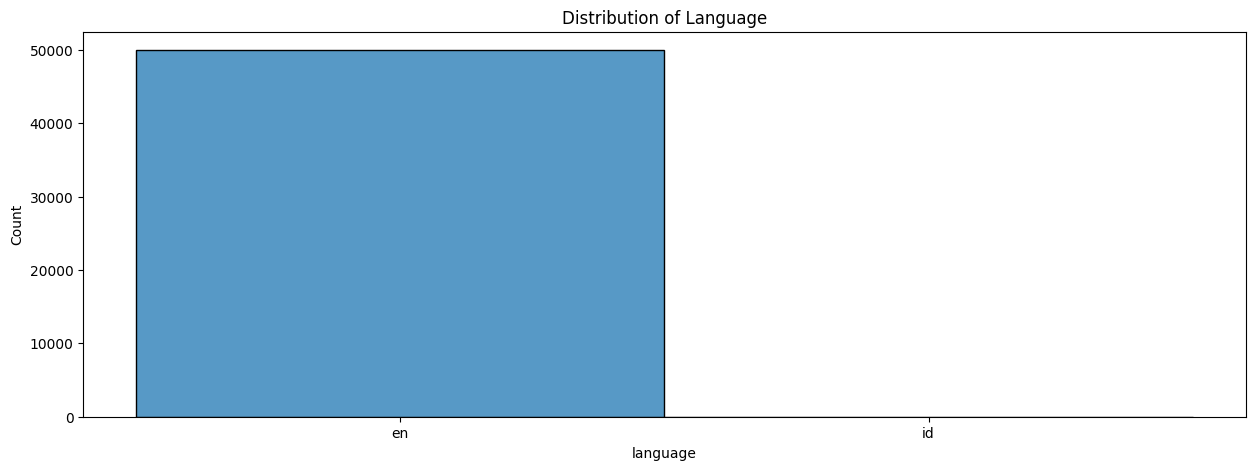

In [5]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=data['language'])
plt.title("Distribution of Language")
plt.show()

Since there's only 1 review identified as non-english, we assume the dataset is english-based, and no non-English content is present.

#### Basic Cleaning
Removes stopwords, special characters, single characters and multiple spaces.



In [6]:
# Text preprocessing
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_text(text):
    # Uniode text
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    
    text = text.lower() # Lowercase text
    
    text = re.sub(r'\W', ' ', text) # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    text = re.sub(r'#', '', text)# Remove hashtag sign
    
    # Remove possible links
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    
    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"there\'s", "there is", text)
    text = re.sub(r"nothing\'s", "nothing is", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)
    return text

def remove_punc(text):
    text =  text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split()])
    return text

additional_stopwords = ["``","''","br",'--', 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb', 'e']
STOPWORDS = set(stopwords.words('english')+additional_stopwords)
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # Remove stopwords from text
    return text

In [7]:
data['cleaned_review'] = data['review'].progress_apply(strip_html).apply(clean_text).apply(decontracted).apply(remove_punc).apply(remove_stopwords)
data.head()

100%|██████████| 50000/50000 [00:07<00:00, 6373.40it/s]


,review,sentiment,language,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...


#### Stemming
Stemming adheres to predefined rules to remove suffixes like "ing," "ed," "es," and others. While it's fast, it may result in peculiar words. Doing stemming helps reduce noise in the corpus

In [8]:
def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

In [9]:
data['cleaned_stemmed_review'] = data['cleaned_review'].progress_apply(stem_text)
data.head()

100%|██████████| 50000/50000 [02:55<00:00, 284.54it/s]


,review,sentiment,language,cleaned_review,cleaned_stemmed_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...,petter mattei love time money visual stun film...


In [10]:
print("========== number of words in the corpus ==========")

print(f"original: {data['review'].apply(lambda x: len(x.split())).sum()}")

print(f"after basic cleaning: {data['cleaned_review'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {data['cleaned_stemmed_review'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 11557847
after basic cleaning: 5965854
after stemming: 5969055


After cleaning and stemming, the noise of the text corpus decreased largely

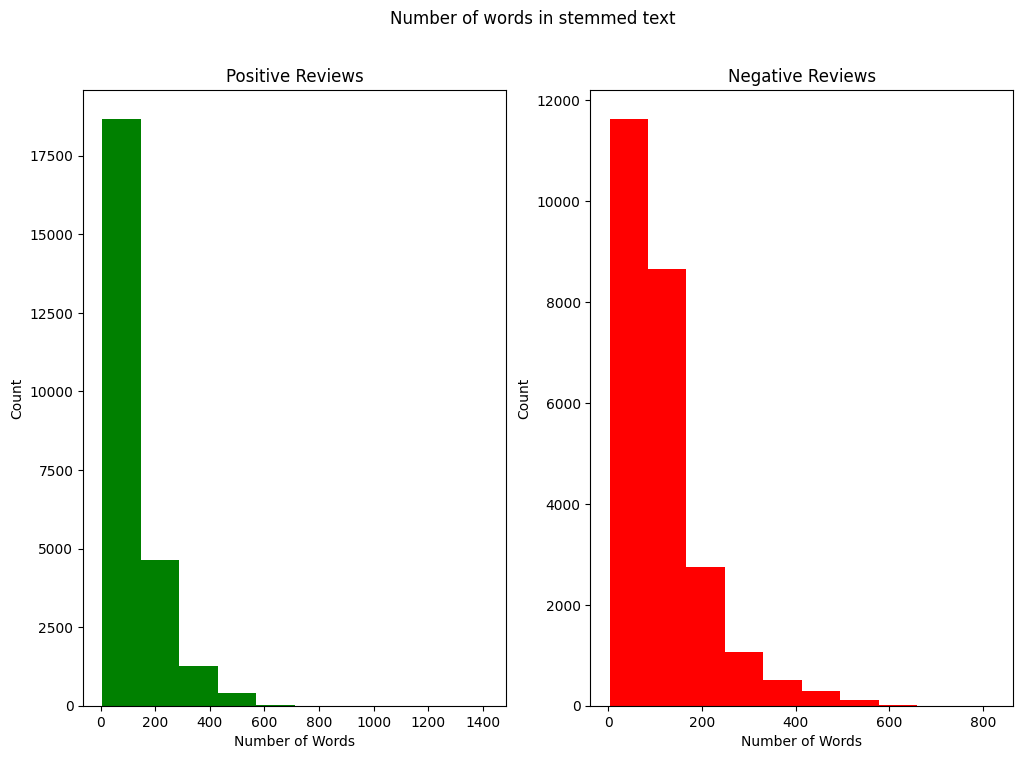

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=data[data['sentiment'] == 'positive']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=data[data['sentiment'] == 'negative']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in stemmed text')
plt.show()

<a id="visualization"></a>
### [1.3. Data Visualization](#content)

To obtain an overview of the dataset, we perform some basic data visualisation in this section.
We will be able to make more informed decisions by using data visualisation to gain insights into the data that will inform our analysis and modelling. 

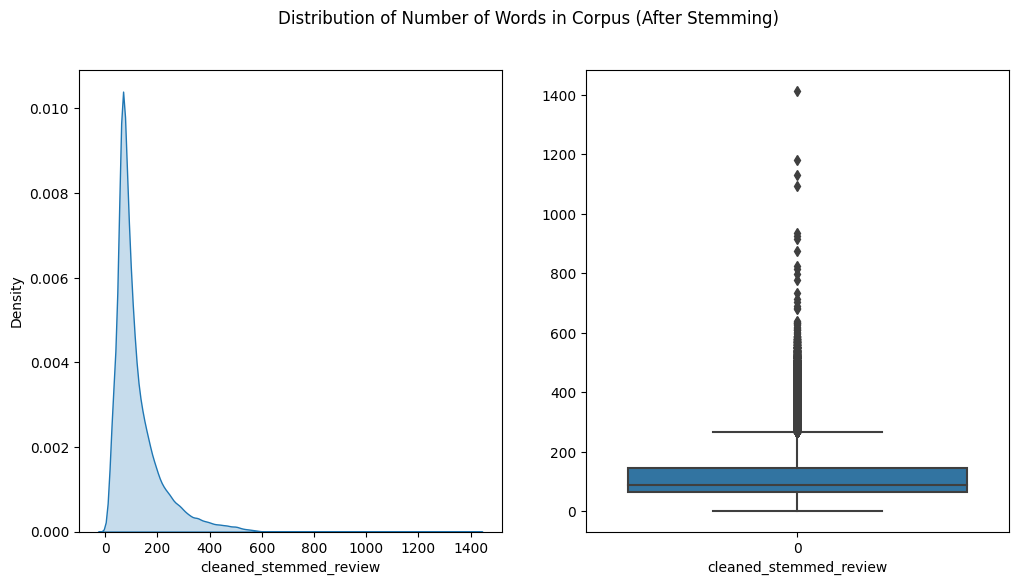

In [12]:
# Investigate word distribution for stemmed text
num_words_train = data['cleaned_stemmed_review'].apply(lambda x: len(x.split()))
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.kdeplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), fill=True, ax=axes[0])
sns.boxplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), ax=axes[1])
axes[1].set_xlabel("cleaned_stemmed_review")
fig.suptitle('Distribution of Number of Words in Corpus (After Stemming)')
plt.show()

In [13]:
# Find the top 25 most common words
word_list = data['cleaned_review'].str.split()
top = Counter([item for sublist in word_list for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['common_words','count']
temp.style.background_gradient(cmap='Blues')

,common_words,count
0,movie,87937
1,film,79674
2,one,53585
3,like,40160
4,good,29737
5,time,25100
6,even,24855
7,would,24599
8,story,23110
9,really,23089


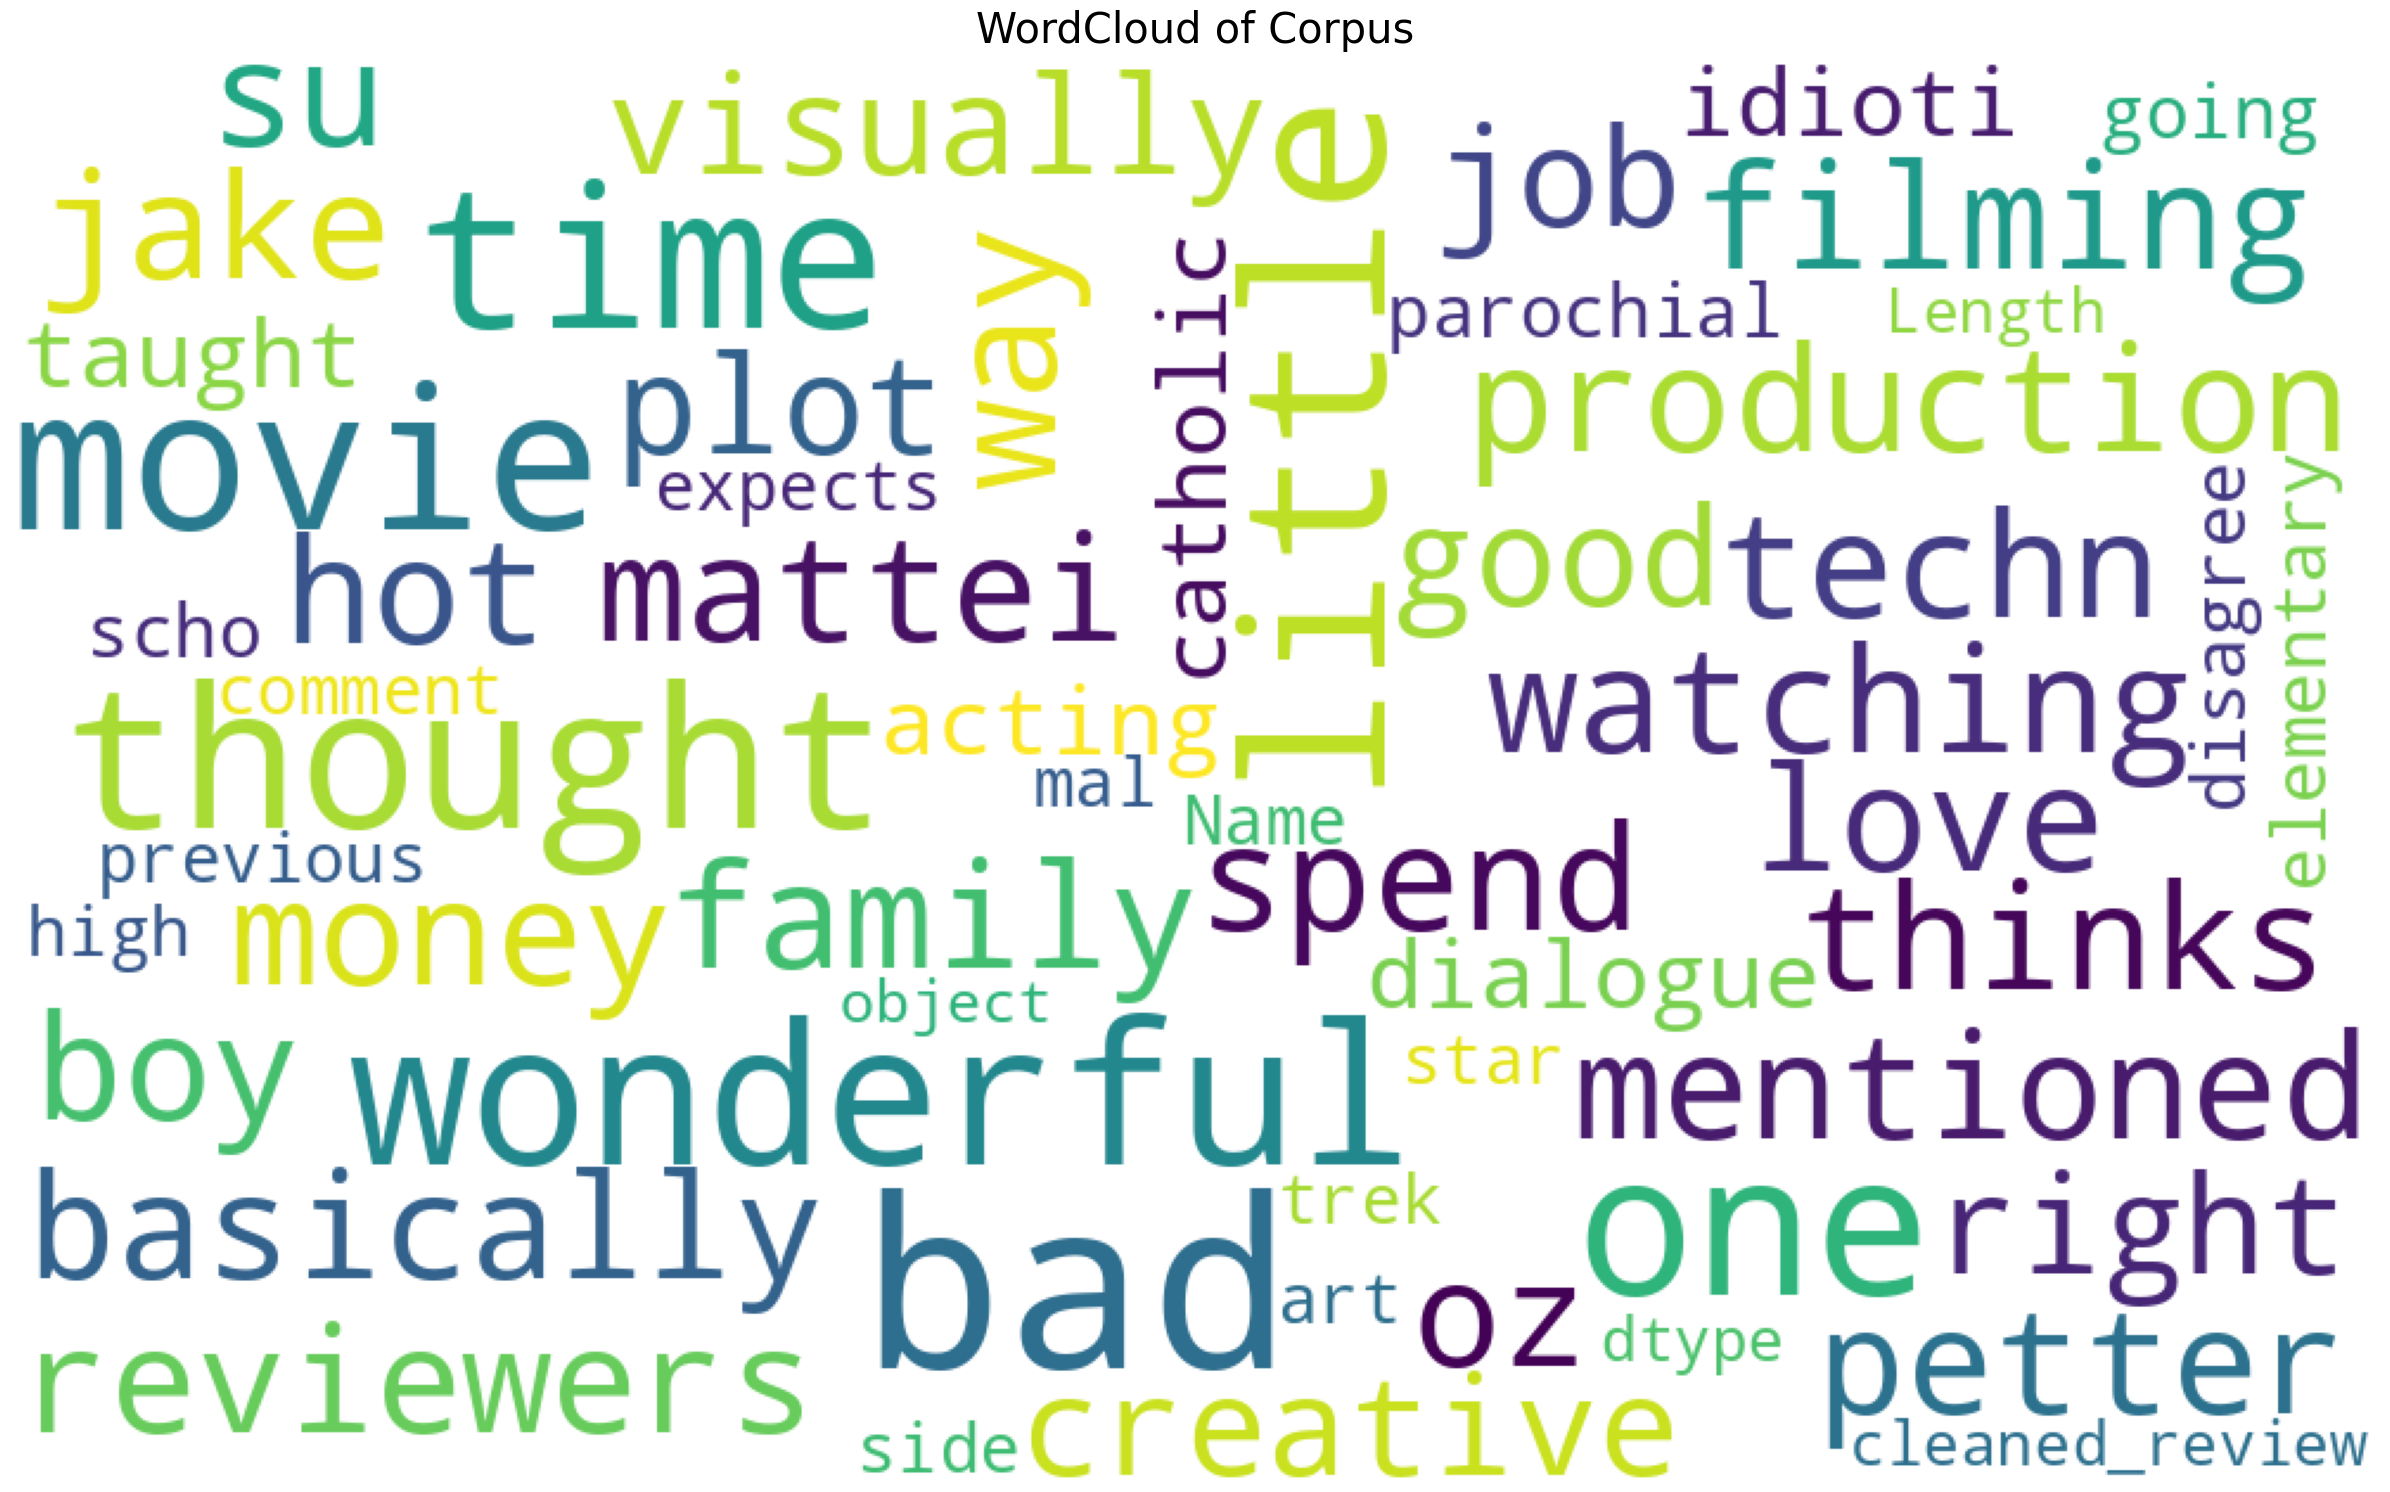

In [14]:
# Plot wordcloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 5,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

<a id="vectorization"></a>
### [1.4. Vectorization](#content)

Vectorization is a must for classifier training. Before tokenization, we will additionally divide the dataset into train, validation, and test groups. To prevent data leaks, we will only apply vector transform to the train data.

#### Train, Validation, Test split

Before splitting the dataset, let's convert the sentiment column to label and examine the balanceness of the label

In [15]:
features = ['cleaned_review', 'cleaned_stemmed_review']
target='sentiment'

# Converting categorical labels to numbers.
data[target] = pd.get_dummies(data[target]).values
print('Shape of label tensor:', data[target].shape)

# Show label counts
data[target].value_counts()

Shape of label tensor: (50000,)


sentiment
False    25000
True     25000
Name: count, dtype: int64

Since the Y label is well balanced, we don't need to under/over sample to balance the dataset, let's move on to train/test/cv split

In [16]:
# Split the dataset into 0.6:0.2:0.2 by default
# Use stratify to ensure that label are still balanced after split
def split_data(X, Y, test_size=0.2, val_size = 0.2, seed=42):
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y,
                                                        test_size = test_size, 
                                                        random_state = seed, stratify=Y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                        y_train_valid,
                                                        test_size = val_size/(1-test_size), 
                                                        random_state = seed, stratify=y_train_valid)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data[features], data[target])
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_val.shape}")
print(f"Shape of y_valid: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (30000, 2)
Shape of y_train: (30000,)
Shape of X_valid: (10000, 2)
Shape of y_valid: (10000,)
Shape of X_test: (10000, 2)
Shape of y_test: (10000,)


#### Vectorization
There are numerous text vectorization techniques in NLP. The following methods will be used to gather data that will be useful later on.

1. **Index Vectorization:** Index vectorization is a basic technique that uses a unique index or identifier for every word or token in the text to transform text data into a numerical format. We can represent textual content in a machine-readable format with the aid of this straightforward but efficient technique, opening up new possibilities for modelling and analysis.

2. **Bag of Words (BoW):** The Bag of Words technique is a traditional text vectorization method that concentrates on word frequency within a document, ignoring word order. Every document is represented as a vector in this way, with each dimension denoting a distinct word across the corpus. This method reduces textual data to a numerical form, which makes it appropriate for a range of NLP applications.


3. **TF-IDF (Term Frequency-Inverse Document Frequency):** Beyond word frequency, TF-IDF vectorization is a popular technique in natural language processing. It weighs words according to their significance within a given document and takes into account their frequency throughout the entire corpus. TF-IDF gives words that are specific to a document more weight than words that are more common throughout the dataset, which aids in capturing the meaning of words in context.

These vectorization techniques provide us with distinct insights into our textual data, which we will examine and gather in the following sections. Our upcoming sentiment analysis models and assessments will be built upon these vectorized representations.

In [17]:
X_train_dict = {}
X_val_dict = {}
X_test_dict = {}

methods = ['index', 'bow', 'tfidf']

# Max number of words in each sequence, choose 600 as most of the reviews is under 600 number of words
MAX_SEQUENCE_LENGTH = 500 # Also length of feature
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# This is fixed.
EMBEDDING_DIM = 100

We tokenize the cleaned texts and turn them into numerical sequences using index vectorization. The sequences are then padded to the same length.

In [18]:
def keras_token_transform(tokenizer, X):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    return X

# keras defaults to index vectorization
def index_vectorization(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    
    X_train_vec = keras_token_transform(tokenizer, X_train)
    X_val_vec = keras_token_transform(tokenizer, X_val)
    X_test_vec = keras_token_transform(tokenizer, X_test)
    return X_train_vec, X_val_vec, X_test_vec

method = methods[0]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = index_vectorization(X_train[feature].values, X_val[feature].values, X_test[feature].values) 
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

With bag of words vectorization

In [19]:
def bow_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_vec =  clf.transform(X_train).toarray()
    X_val_vec = clf.transform(X_val).toarray()
    X_test_vec = clf.transform(X_test).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[1]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = bow_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

With tfidf vectorization

In [20]:
def tfidf_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_cnt_vec =  clf.transform(X_train)
    X_valid_cnt_vec = clf.transform(X_val)
    X_test_cnt_vec = clf.transform(X_test)
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cnt_vec)
    X_train_vec = tf_transformer.transform(X_train_cnt_vec).toarray()
    X_val_vec = tf_transformer.transform(X_valid_cnt_vec).toarray()
    X_test_vec = tf_transformer.transform(X_test_cnt_vec).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[2]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = tfidf_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

In [21]:
for method in methods:
    for feature in features:
        print(f"Shape of {feature} X_train after {method} vectorization", X_train_dict[f'{method}_{feature}'].shape)

Shape of cleaned_review X_train after index vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after index vectorization (30000, 500)
Shape of cleaned_review X_train after bow vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after bow vectorization (30000, 500)
Shape of cleaned_review X_train after tfidf vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after tfidf vectorization (30000, 500)


In [22]:
def save_data(data_dict, file_name):
    # Open the file in binary write mode and save the dictionary
    with open(file_name, 'wb') as file:
        pickle.dump(data_dict, file)

def load_data(file_name):
    loaded_data = {}
    # Open the file in binary read mode and load the dictionary
    with open(file_name, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

For fast reloading of the data

In [23]:
# Save vectorized data
save_data(X_train_dict, "x_train_dict.pkl")
save_data(X_test_dict, "x_test_dict.pkl")
save_data(X_val_dict, "x_val_dict.pkl")

In [24]:
X_train_dict = load_data("x_train_dict.pkl")
X_test_dict = load_data("x_test_dict.pkl")
X_val_dict = load_data("x_val_dict.pkl")

<a id="models"></a>
## [2. Neural Networks](#content)

In this second installment of our exploration of Text Sentiment Analysis (TSA), we move from the preliminary dataset exploration to the main focus of our study, which is creating and assessing sentiment classification models. We can now fully utilise the power of different machine learning and deep learning models to classify sentiments within textual content because our data has been properly preprocessed and vectorized.

<a id="naive"></a>
### [2.1. Naive Bayes Classification](#content)

Our baseline model will be Naive Bayes. We examine the Naive Bayes classification algorithm in this section, which is a straightforward but powerful probabilistic technique for sentiment analysis. We'll examine how this approach uses the vectorized data to predict sentiment and comprehend its advantages and disadvantages.

Referencing the print_eval in the transformer section: [Transformer Preprocessing](#transformers_preproc)

In [25]:
def print_eval(y_test, result, title, ax=None):
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(6,6))
    
    confuse = metrics.confusion_matrix(y_test, result)
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    sns.heatmap(confuse, annot = True, fmt='d', ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print(f"---------- Evaluation Metrics for {title} ----------\n")
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}\n'.format(average_precision))

def naive_bayes_train_test(x_train, y_train, x_test, y_test, ax, title):

    model = MultinomialNB().fit(x_train, y_train)
    result = model.predict(x_test)
    
    print_eval(y_test, result, title, ax)

---------- Evaluation Metrics for index_cleaned_review ----------

F1 score: 0.635
Precision score: 0.503
Recall score: 0.862
Average precision-recall score: 0.503

---------- Evaluation Metrics for index_cleaned_stemmed_review ----------

F1 score: 0.634
Precision score: 0.503
Recall score: 0.857
Average precision-recall score: 0.502

---------- Evaluation Metrics for bow_cleaned_review ----------

F1 score: 0.814
Precision score: 0.829
Recall score: 0.799
Average precision-recall score: 0.763

---------- Evaluation Metrics for bow_cleaned_stemmed_review ----------

F1 score: 0.816
Precision score: 0.828
Recall score: 0.804
Average precision-recall score: 0.764

---------- Evaluation Metrics for tfidf_cleaned_review ----------

F1 score: 0.819
Precision score: 0.836
Recall score: 0.803
Average precision-recall score: 0.769

---------- Evaluation Metrics for tfidf_cleaned_stemmed_review ----------

F1 score: 0.819
Precision score: 0.835
Recall score: 0.804
Average precision-recall scor

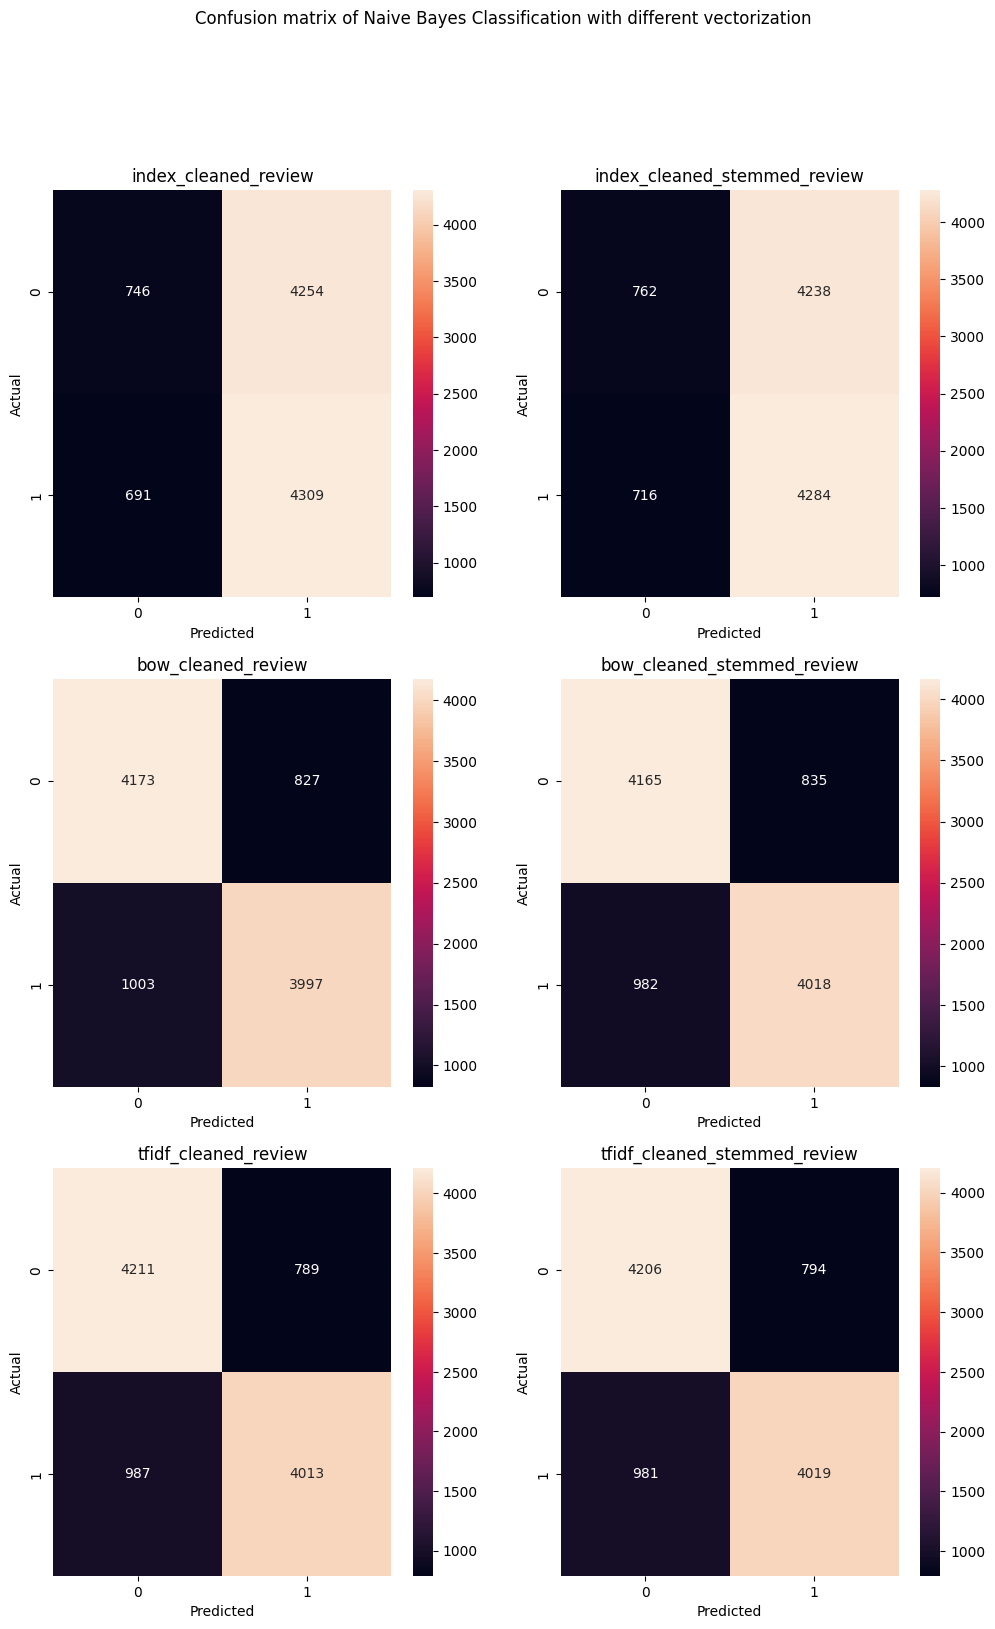

In [26]:
fig, axes = plt.subplots(len(methods), len(features), figsize=(6*len(features), 6*len(methods)))
for i in range(len(methods)):
    for j in range(len(features)):
        method = methods[i]
        feature = features[j]
        naive_bayes_train_test(X_train_dict[f'{method}_{feature}'], y_train, X_test_dict[f'{method}_{feature}'], y_test, ax=axes[i,j], title=f'{method}_{feature}')
        
fig.suptitle(f"Confusion matrix of Naive Bayes Classification with different vectorization")
plt.show()

Using tfidf vectorization, NaiveBayes performs optimally when dealing with stemmed text. This finding supports our hypothesis that stemming text will lower noise in the data, thereby enhancing model performance.

<a id="lstm"></a>
### [2.2. Long Short Term Memory (LSTM) Classification](#content)

This section introduces Long Short Term Memory (LSTM), a kind of recurrent neural network (RNN), to the realm of deep learning. LSTMs are a useful tool for TSA because of their reputation for being able to extract sequential information from text data. We will discuss how to apply LSTM-based models to sentiment analysis.

Since we are running high-dimensional large dataset, using TPU will significantly reduce training time, we are using the TPU on kaggle and training on stemmed text with index vectorization

In [27]:
try:
    tpu_cluster = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu_cluster.master())
except ValueError:
    tpu_cluster = None # It assigns None to the tpu_cluster variable, indicating that no TPU is available

if tpu_cluster: # is not None
    tf.config.experimental_connect_to_cluster(tpu_cluster)
    tf.tpu.experimental.initialize_tpu_system(tpu_cluster)
    dist_strategy = tf.distribute.TPUStrategy(tpu_cluster) # use a distribution strategy related to the presence of TPU 
else: # is None
    dist_strategy = tf.distribute.get_strategy() # use a distribution strategy related to the absence of TPU 

print('The number of Replica involved in strategy :', dist_strategy.num_replicas_in_sync)

The number of Replica involved in strategy : 1


In [28]:
# utility function for plotting
def history_plot(history):
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
    # Get the training loss and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the training accuracy and validation accuracy from the history object
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss and accuracy on a single ax
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def predict_eval(model, X_test, y_test, title):
    # Generate predictions for the test dataset and plot cf_mtx
    result = model.predict(X_test)
    result = result>0.5

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    print_eval(y_test, result, title, ax)
    plt.show()

In [29]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
# Create the model
with dist_strategy.scope():
    lstm_model_index = create_lstm_model()

lstm_model_index.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_dict['index_cleaned_stemmed_review'].shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                         y_train,
                         epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val),
                        callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 465s 493ms/step - loss: 0.3563 - accuracy: 0.8476 - val_loss: 0.2772 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 462s 492ms/step - loss: 0.2153 - accuracy: 0.9165 - val_loss: 0.3382 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 464s 495ms/step - loss: 0.1369 - accuracy: 0.9511 - val_loss: 0.3500 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 467s 497ms/step - loss: 0.0642 - accuracy: 0.9788 - val_loss: 0.3901 - val_accuracy: 0.8875 - lr: 2.0000e-04
Epoch 5/10
938/938 [==============================] - 467s 498ms/step - loss: 0.0472 - accuracy: 0.9856 - val_loss: 0.4060 - val_accuracy: 0.8861 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 470s 501ms/step - loss: 0.0343 - accuracy: 0.9911 - val_loss: 0.4445 - val_accuracy: 0.8861 - lr: 4.0000e-05


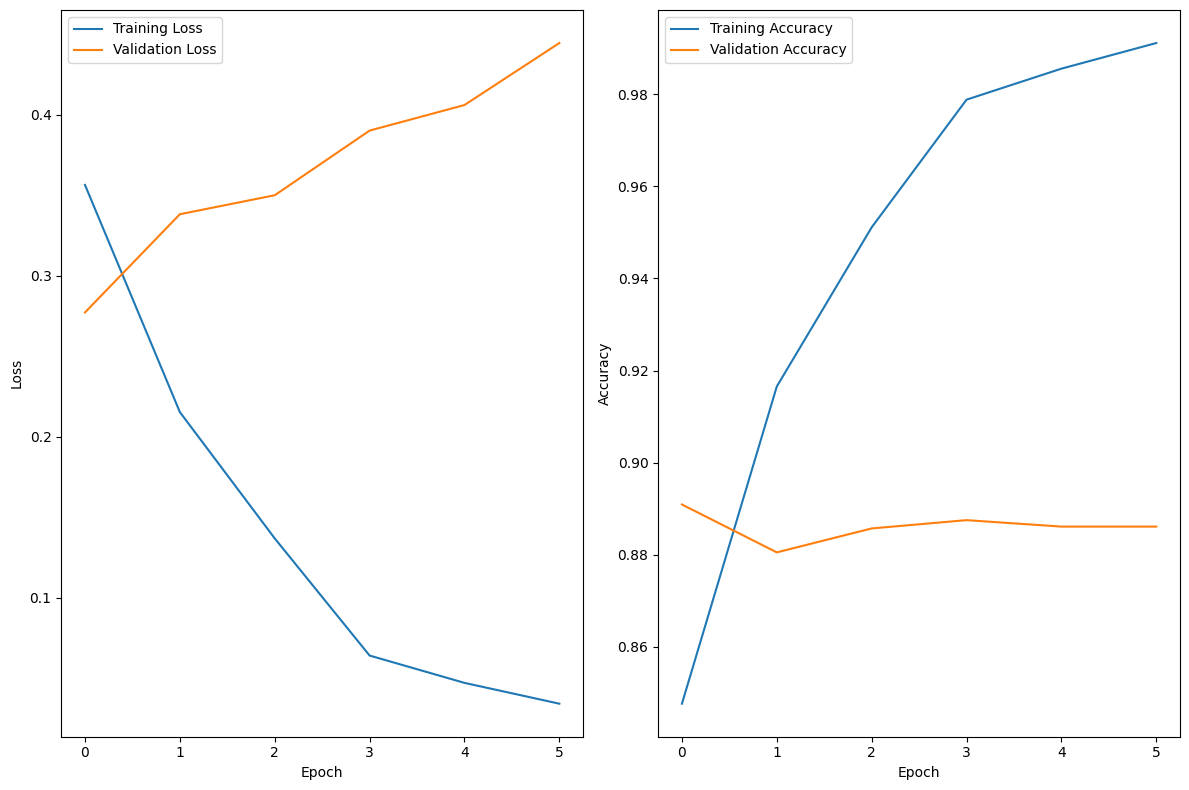

In [32]:
# Show Plot
history_plot(history)

313/313 [==============================] - 20s 63ms/step
---------- Evaluation Metrics for lstm_index_cleaned_stemmed_review ----------

F1 score: 0.881
Precision score: 0.882
Recall score: 0.880
Average precision-recall score: 0.836



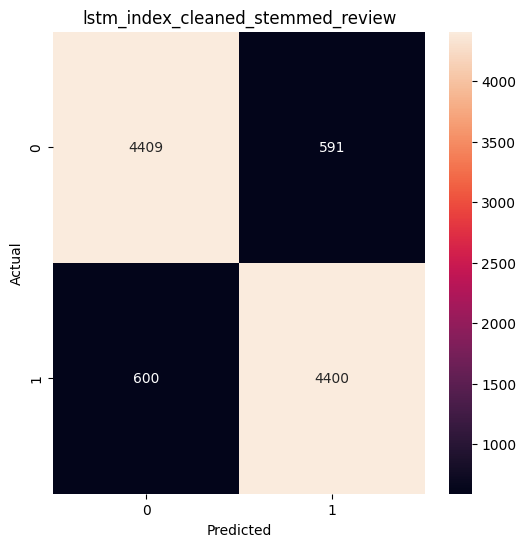

In [33]:
# Evaluation with test set
predict_eval(lstm_model_index, X_test_dict['index_cleaned_stemmed_review'], y_test, 'lstm_index_cleaned_stemmed_review')

<a id="mchcnn"></a>
### [2.3. Multi Channel Convolutional Neural Network(CNN)](#content)

In this section, we continue our exploration of deep learning by looking at the Multi-Channel Convolutional Neural Network (CNN). Although CNNs are best known for their abilities in image processing, they are also very good at text classification jobs. We can extract a variety of features from our text data using MultiChannelCNN, which improves our capacity to accurately classify sentiments.

In [34]:
# Define a function to create a 
# Multi-Channel Convolutional Neural Network (MultiChannelCNN) model
def create_mchcnn_model():
    input1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    # Embedding layer for the first channel
    embedding1 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input1)
    # First set of convolutional layers with a 4-word kernel and ReLU activation
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(conv1)
    # Apply dropout to prevent overfitting
    drop1 = Dropout(0.5)(conv1)
    # Perform max pooling to downsample the feature maps
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    # Flatten the output
    flat1 = Flatten()(pool1)

    input2 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding2 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2= Flatten()(pool2)

    input3 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding3 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)

    input4 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding4 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input4)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(embedding4)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)

    conc = concatenate([flat1, flat2, flat3, flat4])
    dense1 = Dense(128, activation='relu')(conc)
    drop1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(drop1)

    multi_channel_cnn = Model(inputs=[input1, input2, input3, input4], outputs=output)
    multi_channel_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return multi_channel_cnn

with dist_strategy.scope():
    multi_channel_cnn = create_mchcnn_model()

multi_channel_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                              

In [35]:
X_train_selected = X_train_dict['index_cleaned_stemmed_review']
X_val_selected = X_val_dict['index_cleaned_stemmed_review']
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_selected.shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = multi_channel_cnn.fit(
    [X_train_selected, X_train_selected, X_train_selected, X_train_selected],
    y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_selected, X_val_selected, X_val_selected, X_val_selected], y_val),
    callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 230s 243ms/step - loss: 0.3704 - accuracy: 0.8227 - val_loss: 0.2674 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 228s 243ms/step - loss: 0.1493 - accuracy: 0.9451 - val_loss: 0.2599 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 225s 240ms/step - loss: 0.0538 - accuracy: 0.9820 - val_loss: 0.3360 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 224s 238ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 0.3675 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 5/10
938/938 [==============================] - 224s 239ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.5352 - val_accuracy: 0.8860 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 225s 240ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.6341 - val_accuracy: 0.8829 - lr: 2.0000e-04
Epoch 7/10
938/938 [==================

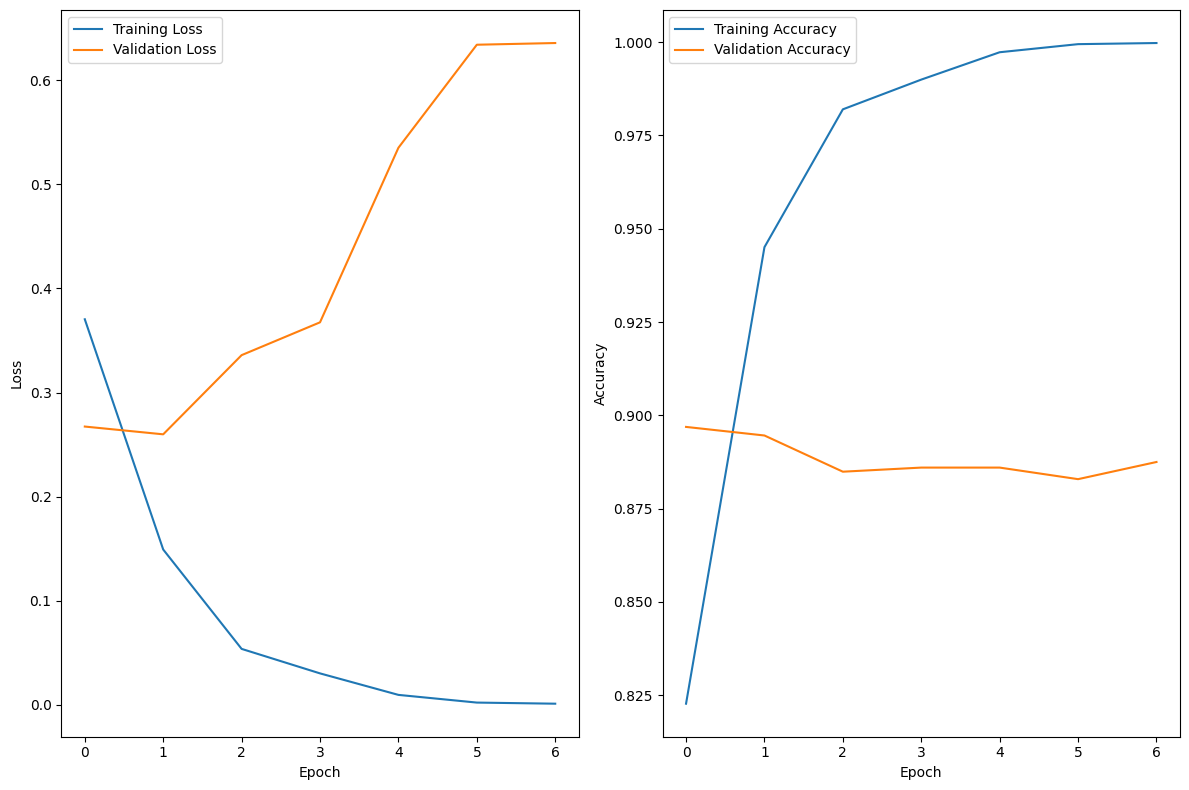

In [36]:
# Show Plot
history_plot(history)

313/313 [==============================] - 11s 33ms/step
---------- Evaluation Metrics for mchcnn_index_cleaned_stemmed_review ----------

F1 score: 0.886
Precision score: 0.877
Recall score: 0.895
Average precision-recall score: 0.838



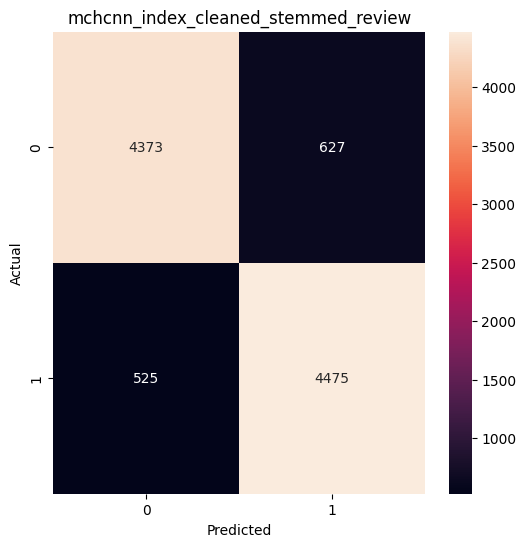

In [37]:
# Evaluate with test set
X_test_selected = X_test_dict['index_cleaned_stemmed_review']
predict_eval(multi_channel_cnn,  [X_test_selected, X_test_selected, X_test_selected, X_test_selected], y_test, 'mchcnn_index_cleaned_stemmed_review')

<a id="cnnlstm"></a>
### [2.4. CNN_LSTM](#content)

In this section, we combine Long Short Term Memory (LSTM) networks and Convolutional Neural Networks (CNNs) in a hybrid approach. The CNN_LSTM model combines the best features of both architectures to offer a strong sentiment analysis solution. We'll look at how these elements work together and how that affects our analysis.

In [38]:
def create_cnn_lstm_model():
    model = Sequential()
    # Embedding Layer: Convert input text into continuous vectors
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    # Batch Normalization: Stabilize and accelerate training by normalizing activations
    model.add(BatchNormalization())
    # Dropout: Prevent overfitting by randomly deactivating a fraction of input units
    model.add(Dropout(0.3))
    # Conv1D: Apply 1D convolution to capture local patterns in the data
    model.add(Conv1D(32,5,activation = 'relu'))
    # Another Dropout layer for regularization
    model.add(Dropout(0.3))
    # MaxPooling1D: Downsample the features extracted by the convolutional layers
    model.add(MaxPooling1D(2))
    # Bidirectional LSTM: Process data in both forward and backward directions
    model.add(Bidirectional(LSTM(128,return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    # LSTM: Further processing of sequential data
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    # Dropout: Additional dropout layer for regularization
    model.add(Dropout(0.5))
    # Dense Layer: Fully connected dense layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

with dist_strategy.scope():
    cnn_lstm_model_index = create_cnn_lstm_model()

cnn_lstm_model_index.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 batch_normalization (BatchN  (None, 500, 100)         400       
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 500, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 496, 32)           16032     
                                                                 
 dropout_6 (Dropout)         (None, 496, 32)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 248, 32)          0         
 1D)                                                  

In [39]:
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_dict['index_cleaned_stemmed_review'].shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=3)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = cnn_lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                         y_train,
                         epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val),
                        callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 704s 744ms/step - loss: 0.3941 - accuracy: 0.8149 - val_loss: 0.2703 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 695s 741ms/step - loss: 0.2030 - accuracy: 0.9238 - val_loss: 0.2804 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 696s 742ms/step - loss: 0.1225 - accuracy: 0.9563 - val_loss: 0.3239 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 700s 746ms/step - loss: 0.0544 - accuracy: 0.9818 - val_loss: 0.3983 - val_accuracy: 0.8938 - lr: 2.0000e-04


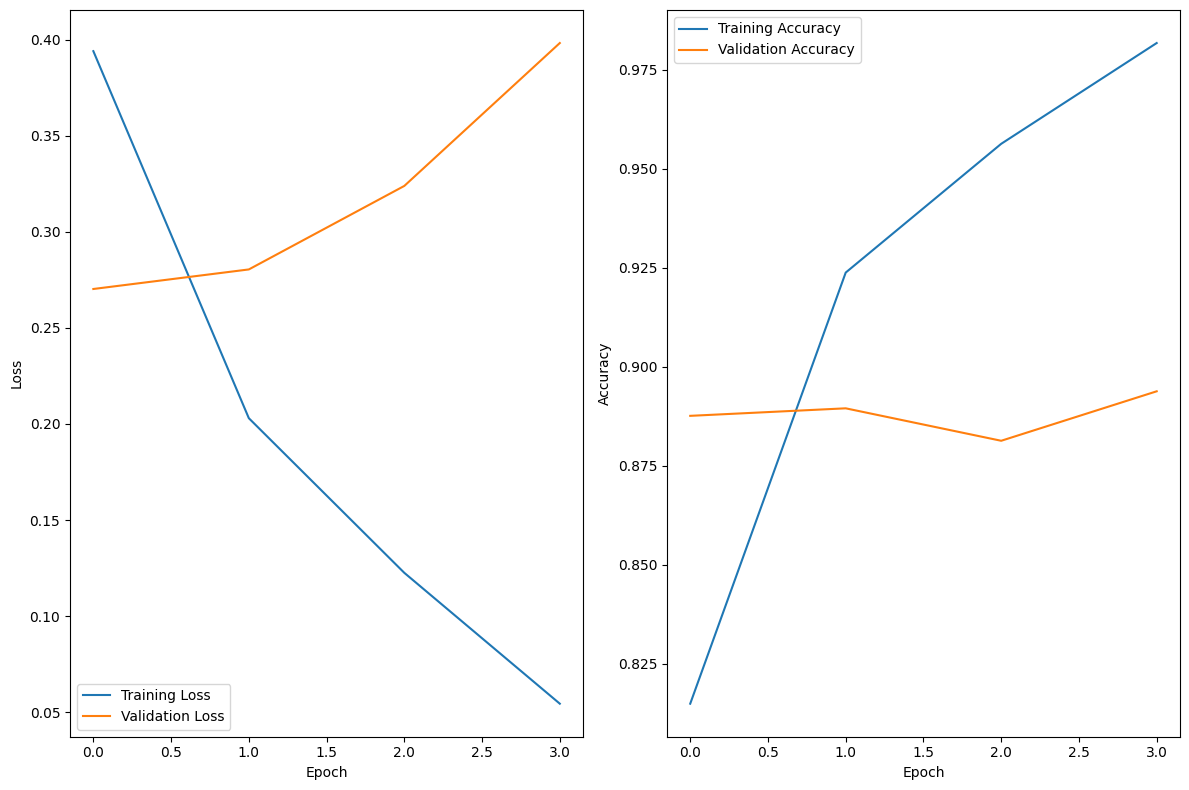

In [40]:
# Show Plot
history_plot(history)

313/313 [==============================] - 28s 88ms/step
---------- Evaluation Metrics for mchcnn_index_cleaned_stemmed_review ----------

F1 score: 0.894
Precision score: 0.901
Recall score: 0.886
Average precision-recall score: 0.856



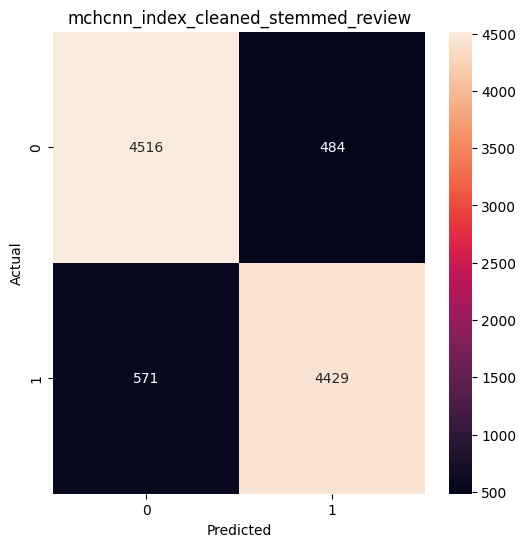

In [41]:
# Evaluate with test set
predict_eval(cnn_lstm_model_index,  X_test_dict['index_cleaned_stemmed_review'], y_test, 'mchcnn_index_cleaned_stemmed_review')

Key findings from our assessment of Text Sentiment Analysis (TSA) models include the following:

1. The CNN-LSTM hybrid model achieved the highest F1 score, precision, and average precision-recall score, outperforming all other models. Convolutional and sequential information are combined in this model in an efficient manner.

2. LSTM performed well, demonstrating its capacity to identify sequential dependencies in text data.

3. The Multi-Channel CNN model demonstrated good performance as well, highlighting the importance of extracting diverse features.

4. While yielding reasonable results, the performance of Naive Bayes was not as good as that of deep learning models.

<a id="transformers"></a>
## [3. Transformers](#content)

For this section, we will be using a small fraction of Stanford Sentiment Treebank and compare the performance of different transformer architectures under the same comperatively smaller dataset.

[Useful notebook for knowledge (Code obsolete)](https://www.kaggle.com/code/maroberti/fastai-with-transformers-bert-roberta/notebook)

[Huggingface auto classes](https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/auto#transformers.AutoModelForSequenceClassification). Example of pre-trained models available on huggingFace:

      ('xlm-mlm-enfr-1024'   ,"XLMModel"),
      
      ('distilbert-base-cased', "DistilBertModel"),
      
      ('bert-base-uncased'     ,"BertModel"),
      
      ('roberta-base'        ,"RobertaModel"),
      
      ("cardiffnlp/twitter-roberta-base-sentiment","RobertaSentTW"),
      
      ('xlnet-base-cased'     ,"XLNetModel"),
      
      ('ctrl'                ,"CTRLModel"),
      
      ('transfo-xl-wt103'    ,"TransfoXLModel"),
      
      ('bert-base-cased'       ,"BertModelUncased"),
      
      ('xlm-roberta-base'     ,"XLMRobertaModel"),
      
      ('openai-gpt'           ,"OpenAIGPTModel"),
      
      ('gpt2'                 ,"GPT2Model")
      

In [42]:
# Below are libraries for part 3
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from fastai.text.all import *

from datasets import load_dataset, concatenate_datasets
from inspect import signature
import gc

# Set see for reproduction
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

<a id="transformers_preproc"></a>
## [3.0. Preprocessing](#content)

SST2 is accessible on huggingFace as a component of the glue dataset. In this section, we load and preprocess the dataset.

We take care of important issues like tokenization, input formatting, and data preparation to ensure that our text data meets the requirements of Transformers that have already been trained. Proper preprocessing is required in order to extract useful information and insights from text data.

In [43]:
# Use number of characters a proxy for length of tokenized text to speed up dls creation.
USE_SMALL_DATASET=True
ds = load_dataset('glue', 'sst2')
ds['train'].shape, ds['validation'].shape, ds['test'].shape

if USE_SMALL_DATASET:
    nv_init = int(len(ds['train'])/20)
    nt_init = nv_init * 2
    nt, nv = min(512, nt_init), min(256, nv_init)
    train_ds = ds['train'].select(range(nt+nv))
    test_ds = ds['train'].select(range(nt+nv, nt+2*nv))
else:
    nv = int(len(ds['train'])/5)
    nt = nv*4
    train_ds = ds['train']# concatenate_datasets([ds['train'], ds['validation']])
    test_ds = ds['validation']

train_idx, valid_idx = L(range(nt)), L(range(nt, nt+nv))
lens = train_ds.map(lambda s: {'len': len(s['sentence'])},
                    remove_columns=train_ds.column_names, num_proc=2, keep_in_memory=True)
train_lens = lens.select(train_idx)['len']
valid_lens = lens.select(valid_idx)['len']

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#0:   0%|          | 0/384 [00:00<?, ?ex/s]

#1:   0%|          | 0/384 [00:00<?, ?ex/s]

#### TokBatchTransform
TokBatchTransform, which wraps a pre-trained HuggingFace tokenizer, will tokenize the inputs. To expedite the process, the text is processed in batches. Whenever possible, we want to avoid using explicit Python loops.

In [44]:
class TokBatchTransform(Transform):
    """
    Tokenizes texts in batches using pretrained HuggingFace tokenizer.
    The first element in a batch can be single string or 2-tuple of strings.
    If `with_labels=True` the "labels" are added to the output dictionary.
    """
    def __init__(self, pretrained_model_name=None, tokenizer_cls=AutoTokenizer, 
                 config=None, tokenizer=None, with_labels=False,
                 padding=True, truncation=True, max_length=None, **kwargs):
        
        if tokenizer is None:
            tokenizer = tokenizer_cls.from_pretrained(pretrained_model_name, config=config)
        self.tokenizer = tokenizer
        self.kwargs = kwargs
        self._two_texts = False
        store_attr()
    
    def encodes(self, batch):
        # batch is a list of tuples of ({text or (text1, text2)}, {targets...})
        if is_listy(batch[0][0]): # 1st element is tuple
            self._two_texts = True
            texts = ([s[0][0] for s in batch], [s[0][1] for s in batch])
        elif is_listy(batch[0]): 
            texts = ([s[0] for s in batch],)

        inps = self.tokenizer(*texts,
                              add_special_tokens=True,
                              padding=self.padding,
                              truncation=self.truncation,
                              max_length=self.max_length,
                              return_tensors='pt',
                              **self.kwargs)
            
        # inps are batched, collate targets into batches too
        labels = default_collate([s[1:] for s in batch])
        if self.with_labels:
            inps['labels'] = labels[0]
            res = (inps, )
        else:
            res = (inps, ) + tuple(labels)
        return res
    
    def decodes(self, x:TensorBase):
        if self._two_texts:
            x1, x2 = split_by_sep(x, self.tokenizer.sep_token_id)
            return (TitledStr(self.tokenizer.decode(x1.cpu(), skip_special_tokens=True)),
                    TitledStr(self.tokenizer.decode(x2.cpu(), skip_special_tokens=True)))

class Undict(Transform):
    '''
    The Undict transform extracts the batch's input_ids and produces TensorBase, 
    which ought to function with typedispatch.
    
    '''
    def decodes(self, x:dict):
        if 'input_ids' in x: res = TensorBase(x['input_ids'])
        return res

#### TransCallback
TransCallback is where the majority of the work required to train the transformer model is done. It creates a tuple from the input dict that the dataloader yielded and saves the valid model argument.

By default, the model produces an object that resembles a dictionary that contains logits and potentially additional outputs specified by the model configuration (such as intermediate hidden representations). Preds is typically expected to be a tensor containing model predictions (logits) in the fastai training loop. The callback correctly formats the preds.

Transformer models calculate the loss and return it along with the output logits if labels are detected in the input. The callback that follows is made to use the loss that the model returns rather than recalculating it with learn.loss_func. Although it isn't used in this example, this could be useful in other situations.

In [45]:
class TransCallback(Callback):
    #Handles HuggingFace model inputs and outputs
    
    def __init__(self, model):
        self.labels = tuple()
        self.model_args = {k:v.default for k, v in signature(model.forward).parameters.items()}
    
    def before_batch(self):
        if 'labels' in self.xb[0].keys():
            self.labels = (self.xb[0]['labels'], )
        # make a tuple containing an element for each argument model excepts
        # if argument is not in xb it is set to default value
        self.learn.xb = tuple([self.xb[0].get(k, self.model_args[k]) for k in self.model_args.keys()])
    
    def after_pred(self):
        if 'loss' in self.pred:
            self.learn.loss_grad = self.pred.loss
            self.learn.loss = self.pred.loss.clone()
        self.learn.pred = self.pred.logits
    
    def after_loss(self):
        if len(self.labels):
            self.learn.yb = self.labels
            self.labels = tuple()


#### Customized Learner
A series of positional arguments are fed into the model by fastai Learner (self.pred = self.model(*self.xb)). We can create a callback to handle unrolling the input dict into the correct xb tuple in order to ensure that everything goes smoothly.

However, we must first define a few utility functions. Model parameters are divided into groups using the default_splitter:

In [46]:
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

#TransLearner itself doesn't do much: 
#it adds TransCallback and sets splitter to be default_splitter if None is provided.
#Example usage: learn = TransLearner(dls, model, metrics=metrics, opt_func=opt_func)
@delegates(Learner.__init__)
class TransLearner(Learner):
    "Learner for training transformers from HuggingFace"
    def __init__(self, dls, model, **kwargs):
        splitter = kwargs.get('splitter', None)
        if splitter is None: kwargs['splitter'] = default_splitter
        super().__init__(dls, model, **kwargs)
        self.add_cb(TransCallback(model))

#### Driver Function: train_binary_classification_task
Here, we define a driver function that combines evrything together: it fine tunes model given the model name, finds the best learning rate, and report the result on test data.

*Note: print_eval function defined under this section: [2.1. Naive Bayes Classification](#naive)*

In [47]:
FOLDER = "fine_tuned_transformers/"
if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

# Train & Test
def train_binary_classification_task(model_name, bs=64, val_batch_size=32, 
                                     opt_func = Adam, n_epoch = 4,lr = 2e-5):
    # Get tokenizer
    tok = TokBatchTransform(pretrained_model_name=model_name, max_length=512)
    
    needs_resize = False
    if tok.tokenizer.pad_token is None:
        needs_resize = True
        tok.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        
    # Get dataset loaders
    dls_kwargs = {
        'before_batch': tok,
        'create_batch': fa_convert
    }
    text_block = TransformBlock(dl_type=SortedDL, dls_kwargs=dls_kwargs, batch_tfms=Undict(), )

    dblock = DataBlock(blocks = [text_block, CategoryBlock()],
                       get_x=ItemGetter('sentence'),
                       get_y=ItemGetter('label'),
                       splitter=IndexSplitter(valid_idx))
    
    dl_kwargs=[{'res':train_lens}, {'val_res':valid_lens}]
    dls = dblock.dataloaders(train_ds, bs=bs, val_bs=val_batch_size, dl_kwargs=dl_kwargs)
    
    # Get Model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2, ignore_mismatched_sizes=True)
    # Resize model tokenizer in case of Out Of Range index error
    
    metrics = accuracy
    if needs_resize:
        print("Needs token_embeddings resize")
        model.resize_token_embeddings(len(tok.tokenizer))
    
    # Get Learner
    learn = TransLearner(dls, 
                         model=model,
                         metrics=metrics, 
                         opt_func=opt_func)    
    try:
        sug_lr = learn.lr_find() # somehow lr_find doesn't work for this model
    except:
        sug_lr = lr

    cbs = [SaveModelCallback(monitor=metrics.__name__)]
    learn.fit_one_cycle(n_epoch, sug_lr, cbs=cbs)
    learn.export(FOLDER+model_name.replace("/", "-"))

    #learn.show_results()

    test_dl = dls.test_dl(test_ds)
    preds = learn.get_preds(dl=test_dl)
    result = np.argmax(preds[0].numpy(), axis=1)
    print_eval(test_ds['label'],result, model_name)
    print("Prediction of the first sample", preds[0][0])
    
    del learn
    del dls
    print("Cleaned memory: ", gc.collect())

<a id="bert"></a>
### [3.1 BERT](#content)

Using [huggingface pretrained model](https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/bert#transformers.BertForSequenceClassification). This bert model is specifically trained for polarity classification. 

**Pros:**
- Reliable and well-established.
- Excellent sentiment analysis results.
- Already trained to classify polarity.

**Cons:**
- The model is rather large.


epoch,train_loss,valid_loss,accuracy,time
0,0.742049,0.675715,0.777344,00:53
1,0.477224,0.485541,0.804688,00:52
2,0.342961,0.500053,0.812500,00:52
3,0.265715,0.510431,0.808594,00:53


Better model found at epoch 0 with accuracy value: 0.77734375.
Better model found at epoch 1 with accuracy value: 0.8046875.
Better model found at epoch 2 with accuracy value: 0.8125.


---------- Evaluation Metrics for textattack/bert-base-uncased-yelp-polarity ----------

F1 score: 0.884
Precision score: 0.896
Recall score: 0.872
Average precision-recall score: 0.855

Prediction of the first sample tensor([0.0427, 0.9573])
Cleaned memory:  1136


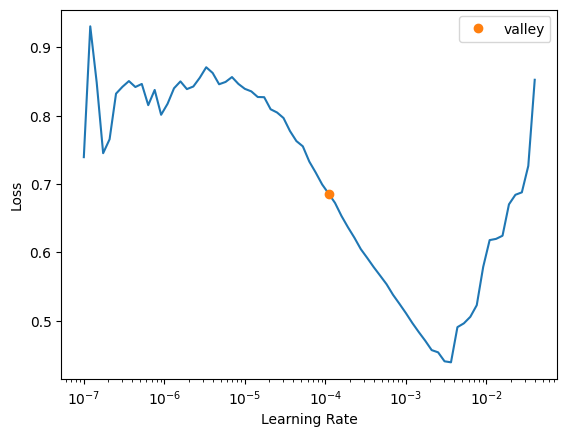

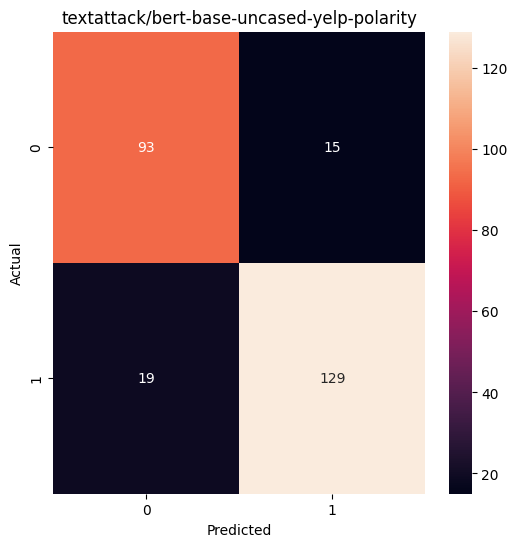

In [48]:
train_binary_classification_task("textattack/bert-base-uncased-yelp-polarity")

<a id="distilbert"></a>
### [3.2 DistilBERT](#content)

Using huggingface pretrained model.


**Pros:**
- Smaller model.
- Faster inference.
- Reasonable performance.

**Cons:**
- Slightly lower performance compared to BERT, but it's usually sufficient for sentiment analysis.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.692406,0.684834,0.617188,00:30
1,0.680151,0.614706,0.796875,00:30
2,0.626384,0.473050,0.847656,00:29
3,0.561024,0.437992,0.863281,00:30


Better model found at epoch 0 with accuracy value: 0.6171875.
Better model found at epoch 1 with accuracy value: 0.796875.
Better model found at epoch 2 with accuracy value: 0.84765625.
Better model found at epoch 3 with accuracy value: 0.86328125.


---------- Evaluation Metrics for distilbert-base-uncased ----------

F1 score: 0.890
Precision score: 0.903
Recall score: 0.878
Average precision-recall score: 0.863

Prediction of the first sample tensor([0.2096, 0.7904])
Cleaned memory:  18496


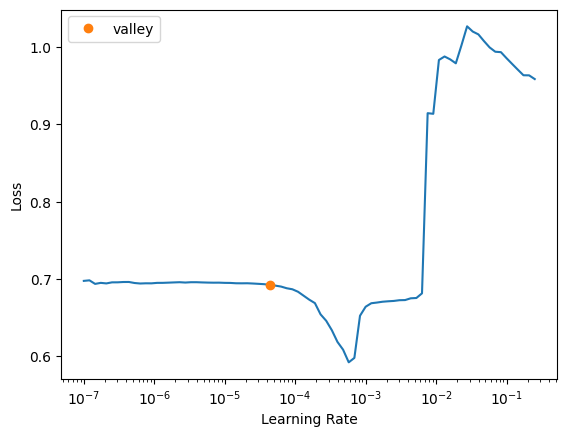

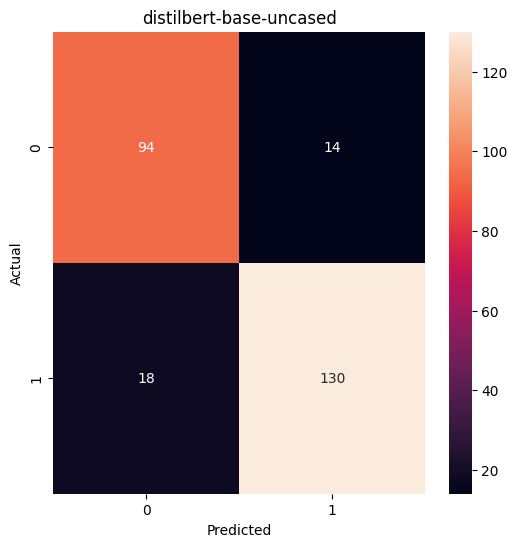

In [49]:
train_binary_classification_task("distilbert-base-uncased")

<a id="distilroberta"></a>
### [3.3. DistilRoBERTa](#content)

This section presents DistilRoBERTa, a compact and potent model renowned for its effectiveness and superior sentiment analysis performance.

**Pros:**
- Lightweight and efficient.
- Strong performance in sentiment analysis.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.690153,0.688772,0.550781,00:30
1,0.688644,0.682178,0.582031,00:30
2,0.681588,0.624505,0.781250,00:30
3,0.657141,0.580416,0.792969,00:30


Better model found at epoch 0 with accuracy value: 0.55078125.
Better model found at epoch 1 with accuracy value: 0.58203125.
Better model found at epoch 2 with accuracy value: 0.78125.
Better model found at epoch 3 with accuracy value: 0.79296875.


---------- Evaluation Metrics for distilroberta-base ----------

F1 score: 0.877
Precision score: 0.822
Recall score: 0.939
Average precision-recall score: 0.808

Prediction of the first sample tensor([0.4236, 0.5764])
Cleaned memory:  19527


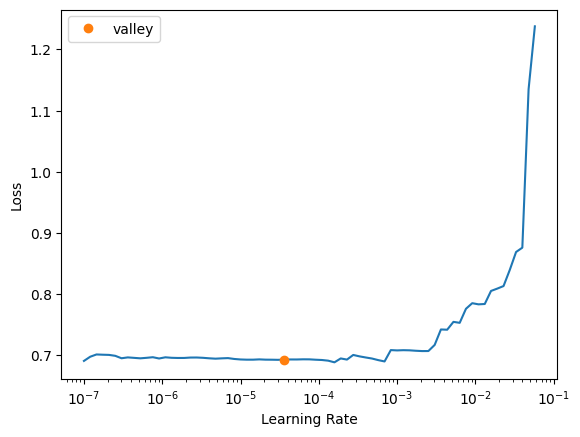

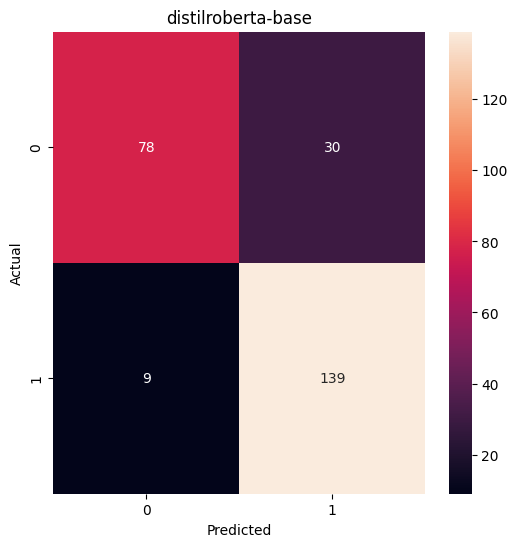

In [50]:
# Parameters
train_binary_classification_task("distilroberta-base")

<a id="bart"></a>
### [3.4 BART](#content)

The potential of BART, which was initially created for text generation, is investigated in relation to sentiment analysis. Even though it wasn't designed for this purpose, it offers special abilities.

**Pros:**
- Specialised text generation skills.
- Possibility of innovative uses for sentiment analysis.

**Cons:**
- Extra fine-tuning might be necessary for sentiment tasks.

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.719223,0.702268,0.453125,01:06
1,0.703911,0.635075,0.636719,01:08
2,0.663290,0.490816,0.792969,01:08
3,0.607154,0.414331,0.847656,01:13


Better model found at epoch 0 with accuracy value: 0.453125.
Better model found at epoch 1 with accuracy value: 0.63671875.
Better model found at epoch 2 with accuracy value: 0.79296875.
Better model found at epoch 3 with accuracy value: 0.84765625.


---------- Evaluation Metrics for facebook/bart-base ----------

F1 score: 0.908
Precision score: 0.885
Recall score: 0.932
Average precision-recall score: 0.864

Prediction of the first sample tensor([0.1606, 0.8394])
Cleaned memory:  20000


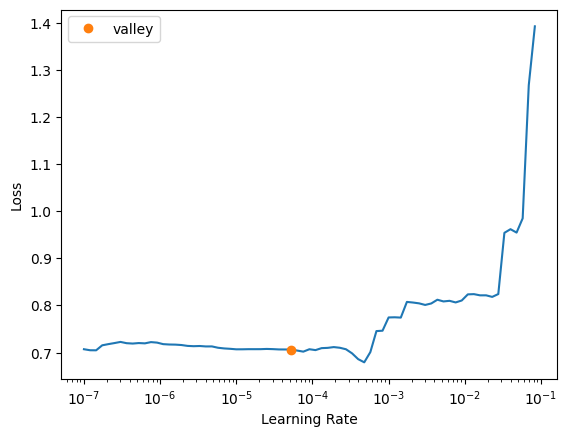

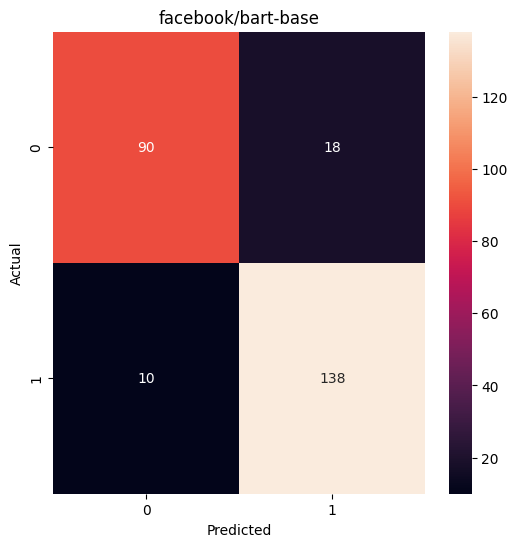

In [51]:
train_binary_classification_task("facebook/bart-base")#"valhalla/bart-large-sst2"

<a id="AlBERT"></a>
### [3.5 ALBERT](#content)

The focus is on ALBERT, which is renowned for its effectiveness and powerful performance. We evaluate its sentiment analysis suitability in light of its distinct architecture.

**Pros:**
- Efficient and high-performing.
- Unique architecture for advanced NLP tasks.

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.711989,0.686759,0.511719,00:58
1,0.680565,0.620094,0.621094,00:59
2,0.630909,0.491793,0.824219,00:59
3,0.556936,0.452097,0.863281,01:04


Better model found at epoch 0 with accuracy value: 0.51171875.
Better model found at epoch 1 with accuracy value: 0.62109375.
Better model found at epoch 2 with accuracy value: 0.82421875.
Better model found at epoch 3 with accuracy value: 0.86328125.


---------- Evaluation Metrics for albert-base-v2 ----------

F1 score: 0.853
Precision score: 0.862
Recall score: 0.845
Average precision-recall score: 0.818

Prediction of the first sample tensor([0.3261, 0.6739])
Cleaned memory:  18897


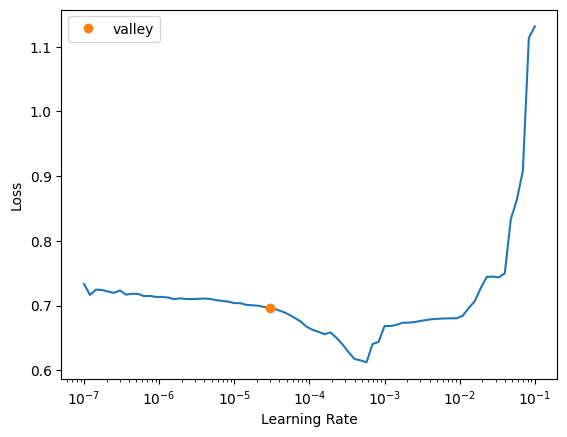

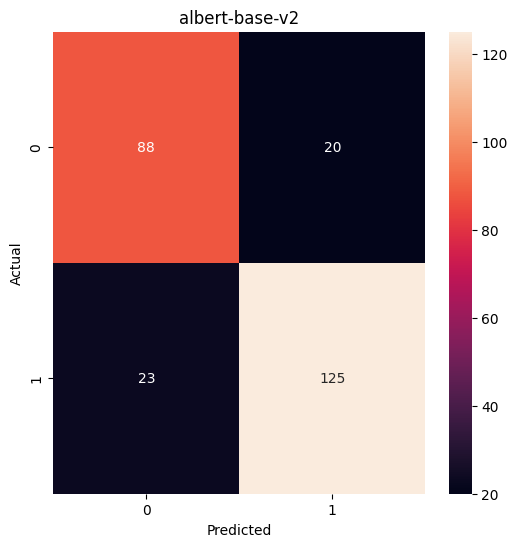

In [52]:
train_binary_classification_task("albert-base-v2")

<a id="ALBERTCls"></a>
### [3.6 ALBERT for Classification](#content)

Here, we utilise the sentiment classification power of ALBERT. We optimise this effective model especially for TSA tasks with the goal of achieving very high performance.

**Pros:**
- Efficient and high-performing.
- Unique architecture for advanced NLP tasks.
- Tailored for sentiment classification.

epoch,train_loss,valid_loss,accuracy,time
0,0.397199,0.376356,0.859375,01:01
1,0.303586,0.375948,0.867188,01:01
2,0.234397,0.374507,0.847656,01:01
3,0.192074,0.376091,0.847656,01:01


Better model found at epoch 0 with accuracy value: 0.859375.
Better model found at epoch 1 with accuracy value: 0.8671875.


---------- Evaluation Metrics for textattack/albert-base-v2-imdb ----------

F1 score: 0.918
Precision score: 0.892
Recall score: 0.946
Average precision-recall score: 0.875

Prediction of the first sample tensor([0.2433, 0.7567])
Cleaned memory:  18661


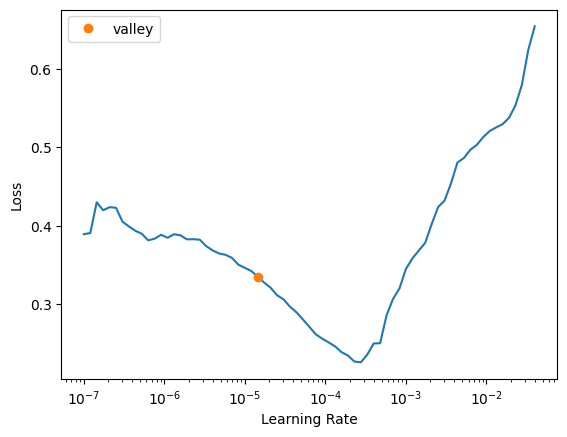

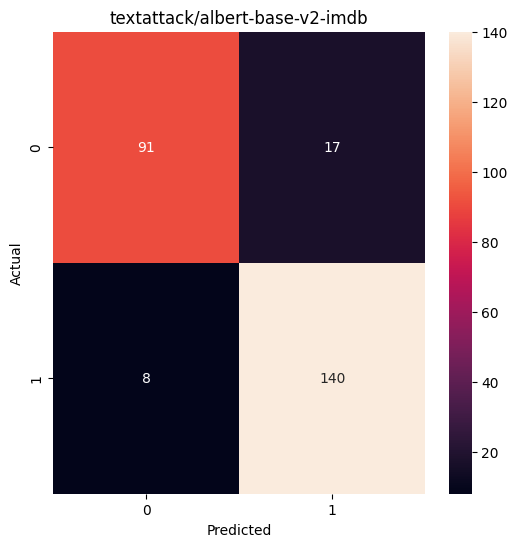

In [53]:
train_binary_classification_task("textattack/albert-base-v2-imdb")

<a id="DeBERTa"></a>
### [3.7 DeBERTa](#content)

Finally, we arrive at DeBERTa, a strong model well-known for its adaptability in NLP applications. We assess its sentiment analysis performance taking into account its distinct architecture.

**Pros:**
- Adaptable to different NLP tasks.
- Excellent sentiment analysis results.
- Provides a large selection of trained variations.

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.705486,0.709065,0.449219,01:05
1,0.701879,0.698024,0.449219,01:12
2,0.700219,0.689869,0.617188,01:07
3,0.697077,0.684653,0.562500,01:05


Better model found at epoch 0 with accuracy value: 0.44921875.
Better model found at epoch 2 with accuracy value: 0.6171875.


---------- Evaluation Metrics for microsoft/deberta-base ----------

F1 score: 0.677
Precision score: 0.648
Recall score: 0.709
Average precision-recall score: 0.628

Prediction of the first sample tensor([0.4882, 0.5118])
Cleaned memory:  18839


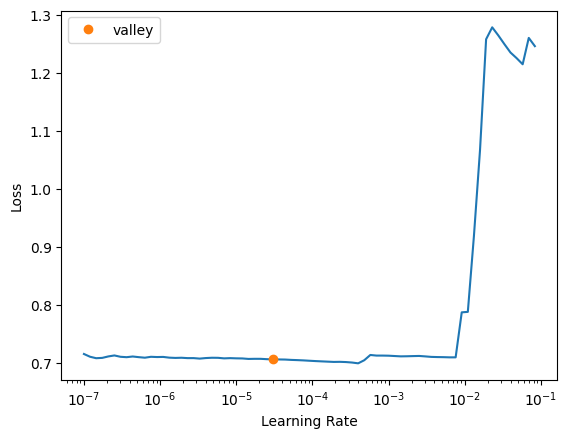

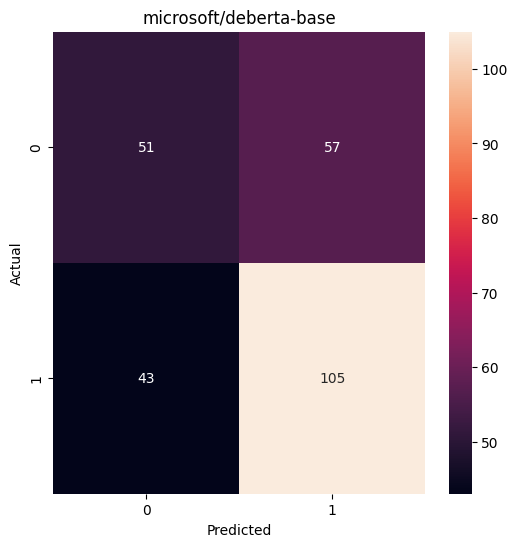

In [54]:
train_binary_classification_task("microsoft/deberta-base") 

In Part 3, we explored the world of Text Sentiment Analysis (TSA) pre-trained Transformer models and assessed their effectiveness using our dataset. These results suggest the following conclusions:

1. In sentiment analysis, BERT, DistilBERT, and DistilRoBERTa perform admirably. Specifically, DistilBERT exhibits high recall.

2. BART shows promise in sentiment analysis, especially in recall, despite being created for text generation.

3. The performance of ALBERT models varies, with "textattack/albert-base-v2-imdb" producing outstanding results, highlighting the importance of model selection.

4. DeBERTa performs less well than other models, which makes it less appropriate for this specific TSA task.

In conclusion, Part 3 has revealed the wide range of abilities of Transformer models that have already been trained for TSA. Depending on the demands of a given task, choosing a model should take a trade-off between precision, recall, and F1 score into account. These results enable us to use Transformers for sentiment analysis with knowledge and confidence.

## Conclusion

We have examined a wide range of methods and models in this thorough investigation into Text Sentiment Analysis (TSA) in order to address the difficulty of comprehending the sentiment conveyed in text. Key requirements that guided our investigation were as follows:

1. **Domain Adaptation:** Using methods like fine-tuning and hyperparameter tuning to enhance domain-specific performance, we tackled the problem of converting models trained on one domain to function well in another.

2. **Comparing Transformers:** To evaluate the efficacy of different Transformer-based pre-trained models, each with distinct advantages, in sentiment analysis, we carried out a thorough comparison.

3. **Small Datasets:** We improved model performance in resource-constrained scenarios by utilising ensemble methods, regularisation techniques, and transfer learning, even with a limited number of training samples.

Important elements like data preprocessing and the application of several model architectures, such as CNN-LSTM hybrids, Multi-Channel CNN, LSTM, and Naive Bayes, were also examined in more detail.

The following are the main realisations we have had:

- The CNN-LSTM hybrid model demonstrated exceptional performance and provided a useful solution for TSA tasks by fusing the advantages of Long Short-Term Memory networks and Convolutional Neural Networks.

- LSTM models are a competitive choice for sentiment analysis because of their demonstrated ability to capture sequential dependencies.

- Optimising pre-trained Transformers, like BERT, DistilBERT, and ALBERT, can produce impressive sentiment analysis outcomes and provide a tried-and-true solution across a range of domains.

- Data preprocessing is just as important as model selection in guaranteeing that the text data satisfies these models' specifications.

Thank you for the attention.